c:\Users\ethan\Documents\GitHub\me241


interactive(children=(IntSlider(value=4, description='fAt', max=8), IntSlider(value=50, description='p1'), Out…

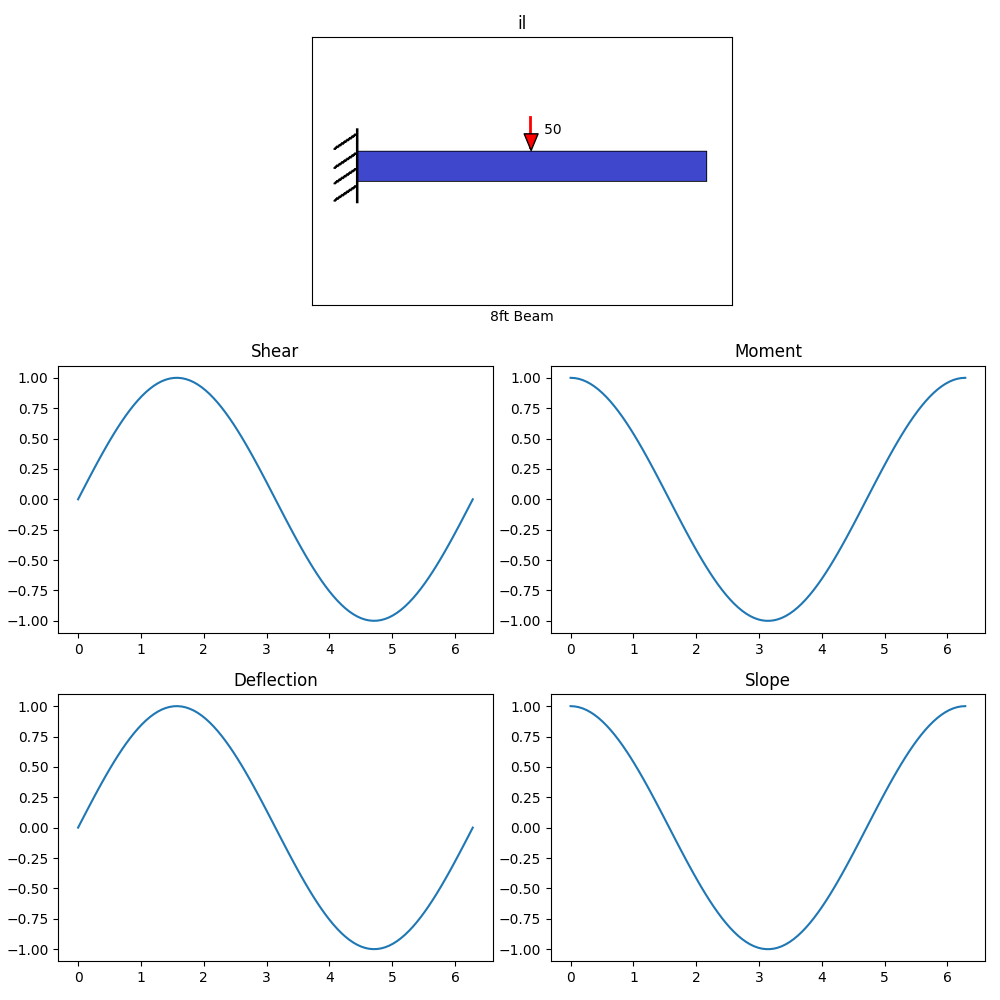

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from sympy import symbols, integrate, solve, diff, lambdify
from scipy.integrate import solve_ivp
from PIL import Image
import urllib.request
from ipywidgets import interactive
from IPython.display import display
import os
print(os.getcwd())

x, p, c1, c2, c3, c4, m0, w, l, E, I = symbols('x p c1 c2 c3 c4 m0 w l E I')
data = np.loadtxt('https://raw.githubusercontent.com/NotInIreland/me241/refs/heads/main/W%20flange%20beams%20sae%20table.csv', dtype=str, skiprows=5, delimiter=',')
id = data[:,0] #identification
depth = data[:,1]
width = data[:,2]
webThick = data[:,3] #web thickness
fThick = data[:,4] #flange thickness
weight = data[:,6]
#dimension = input("What are your beam dimensions? An example input is W 27 x 178")
dimension = 'W 27 x 178'
#beamload = input("What kind of load is on the beam? Your options are intermediate load(IL), uniformly distributed load(UL), triangular distributed load(TL), and moment(M)")
beamload = 'il'
beamload = beamload.lower()
#L = float(input("What is the length of the beam (in ft)"))
L = 8
#Ei = float(input("What is young's modulus for this beam (E value)? This is with assumed units of psi"))
Ei = 29000000
#evalpoint = float(input("Where would you like to evaluate the deflection at, starting with 0 on the left side (in ft)"))
evalpoint = 4

#inertia
def inertia(dimension):
    for i in range(0, len(id)):
        d1 = float(depth[i])
        w1 = float(width[i])
        wt1 = float(webThick[i])
        ft1 = float(fThick[i])
        wh = d1-(2*ft1)
        if id[i] == dimension:
            I = 2*((ft1 * (w1**3))/12)+((wh*(wt1**3))/12)
            break
        else:
            I = 'Unreadable input. Please input dimesion of standard designation including spaces. Example: W # x #.'
    return I

Iin = inertia(dimension)

def W(dimension):
    for i in range(0, len(id)):
        weight1 = weight[i]
        if id[i] == dimension:
            W = float(weight1)
            break
        else:
            W = 'Unreadable input. Please input dimesion of standard designation including spaces. Example: W # x #.'
    return W

def slopecalculate(mgiven, E, I):
    return integrate(mgiven / (E * I), x) + c1
     
def defleccalculate(slopeq):
    return integrate(slopeq, x) + c2 

def values(mgiven, E, I, epointi):
    slopeq = slopecalculate(mgiven, E, I)
    deflecq = defleccalculate(slopeq)

    slopeb = slopeq.subs(x, 0)
    deflecb = deflecq.subs(x, 0)

    c1val = solve(slopeb, c1)[0]
    c2val = solve(deflecb, c2)[0]

    slopec = slopeq.subs(c1, c1val)
    deflectionc = deflecq.subs({c1: c1val, c2: c2val})
    slopeval = slopec.subs(x, epointi).evalf()
    deflecval = deflectionc.subs(x, epointi).evalf()
    return slopeval, deflecval, slopec, deflectionc



#Input = input('Would you like to solve graphically?, yes/no?')
Input = 'yes'
request = Input.lower()
dtype = type(request)
if dtype == str:
    if request == 'yes':

        x_vals = np.linspace(0, L * 12, 500)

        l1i = L * 12
        x1i = fAt * 12

        mgiven = -p * (l - x)
        epointi = evalpoint * 12
        slopeval, deflecval, slopec, deflectionc = values(mgiven, E, I, epointi)
        wfrac = W(dimension)
        beamweight = L * wfrac
        shear = diff(mgiven, x)
        slopeval = slopeval.subs({p: p1, l: l1i, E: Ei, I: Iin})
        deflecval = deflecval.subs({p: p1, l: l1i, E: Ei, I: Iin})
        print(f'The weight of the beam is {beamweight}')
        print(f'The slope equation is {slopec}')
        print(f'The deflection equation is {deflectionc}')
        print(f'The slope value at the point {evalpoint} is {slopeval}')
        print(f'The deflection value at the point {evalpoint} is {deflecval}')
        print(f"The moment equation is {mgiven}")
        print(f"The shear equation is {shear}")
        #ethan
        x = np.linspace(0, 2*np.pi, 100)
        f1 = lambdify(x, shear.subs({p: p1}), 'numpy') #shear
        f2 = lambdify(x, mgiven.subs({p: p1, l: l1i}), 'numpy') #moment
        f3 = lambdify(x, deflectionc.subs({p: p1, l: l1i, E: Ei, I: Iin}), 'numpy') #deflection
        f4 = lambdify(x, slopec.subs({p: p1, l: l1i, E: Ei, I: Iin}), 'numpy') #slope

        fig = plt.figure(figsize=(10, 10))
        gs = fig.add_gridspec(3, 2)

        title = beamload 

        # Image plot
        ax1 = fig.add_subplot(gs[0, :])
        fixed = 'https://raw.githubusercontent.com/NotInIreland/me241/refs/heads/main/fixed.png'
        open = urllib.request.urlopen(fixed)
        img = Image.open(open)
        if beamload == 'il':
            fAt = L / 2
            f = input("Is the load on the beam pushing down? yes/no")
            f = f.lower()
            #457 end and 53 start, total lenght is 404
            def update(fAt, p1): # Update function for interactive plot
                ArrowXValue = 404 * (fAt / L) + 53 # Calculate the x-coordinate where the arrow should point
                ax1.clear() # Clear the current plot
                ax1.imshow(img) # Display the image
                ax1.set_xticks([])  # Remove x-axis ticks
                ax1.set_yticks([])  # Remove y-axis ticks
                ax1.set_title(title) # Set the title of the plot
                ax1.set_xlabel(f'{L}ft Beam') # Set the x-axis label of the plot
                if f == 'no': # If the load is pushing up   
                    arrow_x, arrow_y = ArrowXValue, 165  # Coordinates where the arrow should point
                    ax1.plot([arrow_x, arrow_x], [arrow_y+5, arrow_y + 60], color='red', linewidth=2)
                    ax1.annotate(
                        f'   {p1}',  # Text for the arrow
                        xy=(arrow_x, arrow_y),  # End point of the arrow
                        xytext=(arrow_x, arrow_y + 20),  # Start point of the arrow (20 pixels above the end point)
                        arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=10)
                    )
                else: # If the load is pushing down
                    arrow_x, arrow_y = ArrowXValue, 132  # Coordinates where the arrow should point
                    ax1.plot([arrow_x-1, arrow_x-1], [arrow_y-5, arrow_y - 40], color='red', linewidth=2)
                    ax1.annotate(
                        f'   {p1}',  # Text for the arrow
                        xy=(arrow_x, arrow_y),  # End point of the arrow
                        xytext=(arrow_x, arrow_y - 20),  # Start point of the arrow (20 pixels above the end point)
                        arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=10)
                    )

            fig.canvas.draw()
            interactive_plot = interactive(update, fAt=(0, L, 1), p1=(0, 100, 1))
            display(interactive_plot)

        elif beamload == 'ul':
            ax1.clear()
            ax1.imshow(img)
            ax1.set_xticks([])  # Remove x-axis ticks
            ax1.set_yticks([])  # Remove y-axis ticks
            ax1.set_title(title)
            ax1.set_xlabel(f'{L}m Beam')
            if f > 0:
                arrow_x, arrow_y = 53, 130  # Coordinates where the arrow should point
                ax1.plot([arrow_x, arrow_x+400], [arrow_y-40, arrow_y-40], color='red', linewidth=2)
                for offset in range(0, 405, 40):
                    ax1.plot([arrow_x + offset, arrow_x + offset], [arrow_y - 5, arrow_y - 40], color='red', linewidth=2)
                    ax1.annotate(
                        '   F',  # Text for the arrow
                        xy=(arrow_x + offset, arrow_y),  # End point of the arrow
                        xytext=(arrow_x + offset, arrow_y - 20),  # Start point of the arrow (20 pixels above the end point)
                        arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=10)
                    )
            else:
                arrow_x, arrow_y = 53, 165  # Coordinates where the arrow should point
                ax1.plot([arrow_x, arrow_x+400], [arrow_y+40, arrow_y+40], color='red', linewidth=2)
                for offset in range(0, 405, 40):
                    ax1.plot([arrow_x + offset, arrow_x + offset], [arrow_y + 5, arrow_y + 40], color='red', linewidth=2)
                    ax1.annotate(
                        '   F',  # Text for the arrow
                        xy=(arrow_x + offset, arrow_y),  # End point of the arrow
                        xytext=(arrow_x + offset, arrow_y + 20),  # Start point of the arrow (20 pixels above the end point)
                        arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=10)
                    )

            fig.canvas.draw()
        elif beamload == 'm':
            ax1.clear()
            ax1.imshow(img)
            ax1.set_xticks([])  # Remove x-axis ticks
            ax1.set_yticks([])  # Remove y-axis ticks
            ax1.set_title(title)
            ax1.set_xlabel(f'{L}m Beam')
            moment_x, moment_y = 457, 150
            if f > 0:
                circle = plt.Circle((moment_x, moment_y), 20, color='red', fill=False, linewidth=2)
                ax1.add_patch(circle)
                ax1.annotate(
                    '',  # No text for the arrow
                    xy=(moment_x + 20, moment_y),  # End point of the arrow
                    xytext=(moment_x, moment_y+ 20),  # Start point of the arrow
                    arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=10)
                )
            else:
                circle = plt.Circle((moment_x, moment_y), 20, color='red', fill=False, linewidth=2)
                ax1.add_patch(circle)
                ax1.annotate(
                    '',  # No text for the arrow
                    xy=(moment_x - 20, moment_y),  # End point of the arrow
                    xytext=(moment_x, moment_y + 20),  # Start point of the arrow
                    arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=10)
                    )
                '''
        elif beamload == 'tl':
            ax1.clear()
            ax1.imshow(img)
            ax1.set_xticks([])  # Remove x-axis ticks
            ax1.set_yticks([])  # Remove y-axis ticks
            ax1.set_title(title)
            ax1.set_xlabel(f'{L}m Beam')

                # Draw triangular load
            if f > 0:
                arrow_x, arrow_y = 53, 130  # Coordinates where the arrow should point
                ax1.plot([53, 457], [50, 132], color='red', linewidth=2)
                ax1.plot([53, 53], [50, 132], color='red', linewidth=2)
                for offset in range(0, 320, 40):
                    ax1.plot([arrow_x + offset, arrow_x + offset], [arrow_y - 5, arrow_y - 40], color='red', linewidth=2)
                    ax1.annotate(
                        '   F',  # Text for the arrow
                        xy=(arrow_x + offset, arrow_y),  # End point of the arrow
                        xytext=(arrow_x + offset, arrow_y - 20),  # Start point of the arrow (20 pixels above the end point)
                        arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=10)
                    )
            else:
                ax1.plot([53, 457], [250, 170], color='red', linewidth=2)
                ax1.plot([53, 53], [250, 170], color='red', linewidth=2)

'''
            
            
        # Plot Shear
        ax2 = fig.add_subplot(gs[1, 0])
        ax2.plot(x, f1)
        ax2.set_title('Shear')

        # Plot cos(x)
        ax3 = fig.add_subplot(gs[1, 1])
        ax3.plot(x, f2)
        ax3.set_title('Moment')

        # Plot sin(x)
        ax4 = fig.add_subplot(gs[2, 0])
        ax4.plot(x, f3)
        ax4.set_title('Deflection')

        # Plot cos(x)
        ax5 = fig.add_subplot(gs[2, 1])
        ax5.plot(x, f4)
        ax5.set_title('Slope')

        plt.tight_layout()
        plt.show()

    elif request == 'no':
            if beamload == 'il':
                l1 = float(input("What is the length of the beam (in ft)"))
                l1i = l1 * 12
                x1 = float(input("Where is the load on the beam, starting with 0 on the left side (in ft)"))
                x1i = x1 * 12
                p1 = float(input("What is the load on the beam in units of lbs"))

                mgiven = -p * (l - x)
                evalpoint = float(input("Where would you like to evaluate the deflection at, starting with 0 on the left side (in ft)"))
                epointi = evalpoint * 12
                slopeval, deflecval, slopec, deflectionc = values(mgiven, E, I, epointi)
                wfrac = W(dimension)
                beamweight = l1 * wfrac
                shear = diff(mgiven, x)
                slopeval = slopeval.subs({p: p1, l: l1i, E: Ei, I: Iin})
                deflecval = deflecval.subs({p: p1, l: l1i, E: Ei, I: Iin})
                print(f'The weight of the beam is {beamweight}')
                print(f'The slope equation is {slopec}')
                print(f'The deflection equation is {deflectionc}')
                print(f'The slope value at the point {evalpoint} is {slopeval}')
                print(f'The deflection value at the point {evalpoint} is {deflecval}')
                print(f"The moment equation is {mgiven}")
                print(f"The shear equation is {shear}")
            elif beamload == 'ul':
                l1 = float(input("What is the length of the beam (in ft)"))
                l1i = l1 * 12
                x1 = float(input("Where do you want to measure the deflection of the beam (in ft)"))
                x1i = x1 * 12
                w2 = float(input("What is the magnitude of the distributed load on the beam in units of lbs / ft"))
                w2 = w2 * l1

                mgiven = (-w * (l - x)**2) / 2
                evalpoint = float(input("Where would you like to evaluate the deflection at, starting with 0 on the left side (in ft)"))
                epointi = evalpoint * 12
                slopeval, deflecval, slopec, deflectionc = values(mgiven, E, I, epointi)
                wfrac = W(dimension)
                beamweight = l1 * wfrac
                shear = diff(mgiven, x)
                slopeval = slopeval.subs({w: w2, l: l1i, E: Ei, I: Iin})
                deflecval = deflecval.subs({w: w2, l: l1i, E: Ei, I: Iin})

                print(f'The weight of the beam is {beamweight}')
                print(f'The slope equation is {slopec}')
                print(f'The deflection equation is {deflectionc}')
                print(f'The slope value at the point {evalpoint} is {slopeval}')
                print(f'The deflection value at the point {evalpoint} is {deflecval}')
                print(f"The moment equation is {mgiven}")
                print(f"The shear equation is {shear}")
            elif beamload == 'tl':
                l1 = float(input("What is the length of the beam (in ft)"))
                l1i = l1 * 12
                x1= float(input("Where do you want to measure the deflection of the beam (in ft)"))
                x1i = x1 * 12
                w2 = float(input("What is the magnitude of the distributed load on the beam in units of lbs / ft"))
                w2 = w2 * l1

                mgiven = (-1 / 6) * w * (x**3 / l)
                evalpoint = float(input("Where would you like to evaluate the deflection at, starting with 0 on the left side (in ft)"))
                epointi = evalpoint * 12
                slopeval, deflecval, slopec, deflectionc = values(mgiven, E, I, epointi)
                wfrac = W(dimension)
                beamweight = l1 * wfrac
                shear = diff(mgiven, x)
                slopeval = slopeval.subs({w: w2, l: l1i, E: Ei, I: Iin})
                deflecval = deflecval.subs({w: w2, l: l1i, E: Ei, I: Iin})

                print(f'The weight of the beam is {beamweight}')
                print(f'The slope equation is {slopec}')
                print(f'The deflection equation is {deflectionc}')
                print(f'The slope value at the point {evalpoint} is {slopeval}')
                print(f'The deflection value at the point {evalpoint} is {deflecval}')
                print(f"The moment equation is {mgiven}")
                print(f"The shear equation is {shear}.")
                   
    else:
        print('Please input valid answer of yes or no.')
else:
    print('Please input valid answer of type string.')





c:\Users\ethan\Documents\GitHub\me241


interactive(children=(IntSlider(value=50, description='m03', min=1), Output()), _dom_classes=('widget-interact…

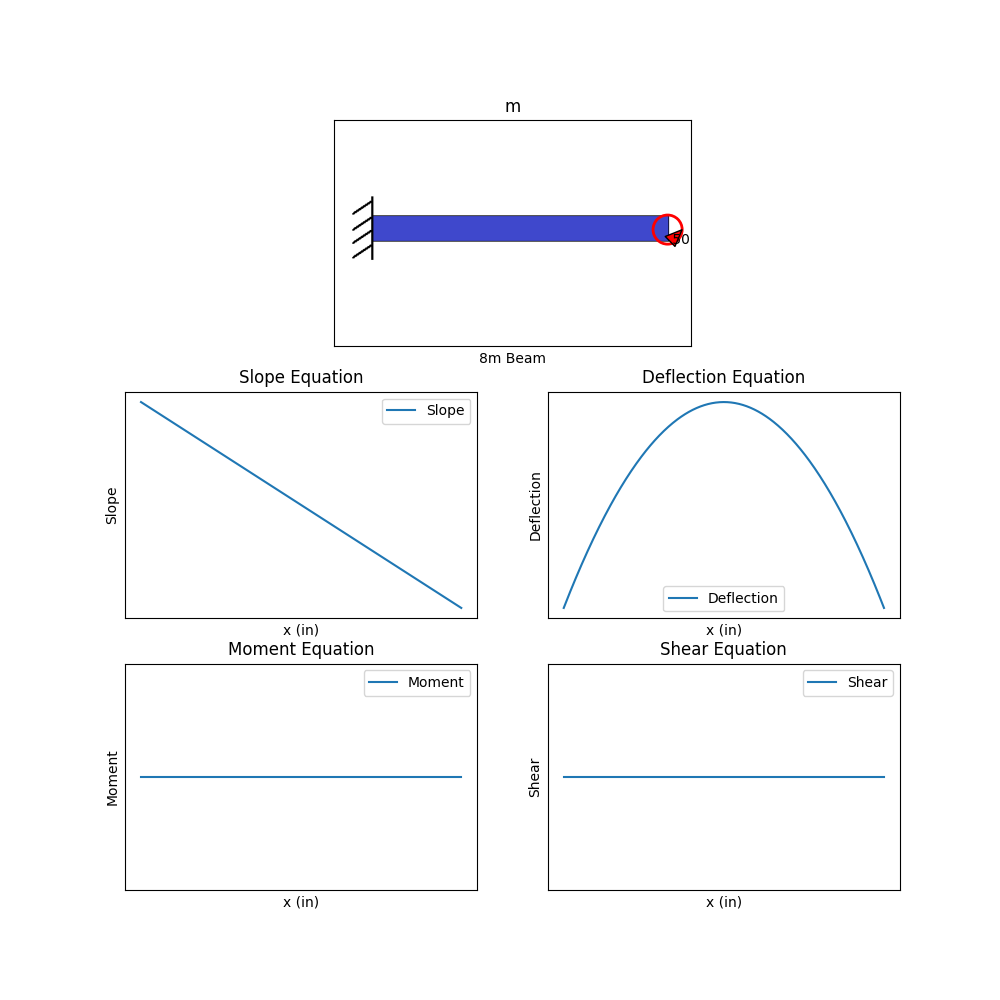

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from sympy import symbols, integrate, solve, diff, lambdify
from scipy.integrate import solve_ivp
from PIL import Image
import urllib.request
from ipywidgets import interactive
from IPython.display import display
import os
print(os.getcwd())

x, p, c1, c2, c3, c4, m0, w, l, E, I = symbols('x p c1 c2 c3 c4 m0 w l E I')
data = np.loadtxt('https://raw.githubusercontent.com/NotInIreland/me241/refs/heads/main/W%20flange%20beams%20sae%20table.csv', dtype=str, skiprows=5, delimiter=',')
id = data[:,0] #identification
depth = data[:,1]
width = data[:,2]
webThick = data[:,3] #web thickness
fThick = data[:,4] #flange thickness
weight = data[:,6]
#dimension = input("What are your beam dimensions? An example input is W 27 x 178")
dimension = 'W 27 x 178'
#beamload = input("What kind of load is on the beam? Your options are intermediate load(IL), uniformly distributed load(UL), triangular distributed load(TL), and moment(M)")
beamload = 'm'
beamload = beamload.lower()
#L = float(input("What is the length of the beam (in ft)"))
L = 8
#Ei = float(input("What is young's modulus for this beam (E value)? This is with assumed units of psi"))
Ei = 29000000
#evalpoint = float(input("Where would you like to evaluate the deflection at, starting with 0 on the left side (in ft)"))
evalpoint = 4

#inertia
def inertia(dimension):
    for i in range(0, len(id)):
        d1 = float(depth[i])
        w1 = float(width[i])
        wt1 = float(webThick[i])
        ft1 = float(fThick[i])
        wh = d1-(2*ft1)
        if id[i] == dimension:
            I = 2*((ft1 * (w1**3))/12)+((wh*(wt1**3))/12)
            break
        else:
            I = 'Unreadable input. Please input dimesion of standard designation including spaces. Example: W # x #.'
    return I

Iin = inertia(dimension)

def W(dimension):
    for i in range(0, len(id)):
        weight1 = weight[i]
        if id[i] == dimension:
            W = float(weight1)
            break
        else:
            W = 'Unreadable input. Please input dimesion of standard designation including spaces. Example: W # x #.'
    return W

def slopecalculate(mgiven, E, I):
    return integrate(mgiven / (E * I), x) + c1
     
def defleccalculate(slopeq):
    return integrate(slopeq, x) + c2 

def values(mgiven, E, I, epointi):
    slopeq = slopecalculate(mgiven, E, I)
    deflecq = defleccalculate(slopeq)

    slopeb = slopeq.subs(x, 0)
    deflecb = deflecq.subs(x, 0)

    c1val = solve(slopeb, c1)[0]
    c2val = solve(deflecb, c2)[0]

    slopec = slopeq.subs(c1, c1val)
    deflectionc = deflecq.subs({c1: c1val, c2: c2val})
    slopeval = slopec.subs(x, epointi).evalf()
    deflecval = deflectionc.subs(x, epointi).evalf()
    return slopeval, deflecval, slopec, deflectionc



#Input = input('Would you like to solve graphically?, yes/no?')
Input = 'yes'
request = Input.lower()
dtype = type(request)
if dtype == str:
    if request == 'yes':
        title = beamload 
        fig = plt.figure(figsize=(10, 10))
        gs = fig.add_gridspec(3, 2)
        ax1 = fig.add_subplot(gs[0, :])
        ax2 = fig.add_subplot(gs[1, 0])
        ax3 = fig.add_subplot(gs[1, 1])
        ax4 = fig.add_subplot(gs[2, 0])
        ax5 = fig.add_subplot(gs[2, 1])
        fixed = 'https://raw.githubusercontent.com/NotInIreland/me241/refs/heads/main/fixed.png'
        open = urllib.request.urlopen(fixed)
        img = Image.open(open)
        if beamload == 'il':
            fAt = L / 2
            f = input("Is the load on the beam pushing down? yes/no")
            f = f.lower()
            #457 end and 53 start, total lenght is 404
            def update(fAt, p1): # Update function for interactive plot
                ArrowXValue = 404 * (fAt / L) + 53 # Calculate the x-coordinate where the arrow should point
                ax1.clear()
                ax2.clear()
                ax3.clear()
                ax4.clear()
                ax5.clear()
                ax1.imshow(img) # Display the image
                ax1.set_xticks([])  # Remove x-axis ticks
                ax1.set_yticks([])  # Remove y-axis ticks
                ax1.set_title(title) # Set the title of the plot
                ax1.set_xlabel(f'{L}ft Beam') # Set the x-axis label of the plot
                if f == 'no': # If the load is pushing up   
                    arrow_x, arrow_y = ArrowXValue, 165  # Coordinates where the arrow should point
                    ax1.plot([arrow_x, arrow_x], [arrow_y+5, arrow_y + 60], color='red', linewidth=2)
                    ax1.annotate(
                        f'   {p1}',  # Text for the arrow
                        xy=(arrow_x, arrow_y),  # End point of the arrow
                        xytext=(arrow_x, arrow_y + 20),  # Start point of the arrow (20 pixels above the end point)
                        arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=10)
                    )
                else: # If the load is pushing down
                    arrow_x, arrow_y = ArrowXValue, 132  # Coordinates where the arrow should point
                    ax1.plot([arrow_x-1, arrow_x-1], [arrow_y-5, arrow_y - 40], color='red', linewidth=2)
                    ax1.annotate(
                        f'   {p1}',  # Text for the arrow
                        xy=(arrow_x, arrow_y),  # End point of the arrow
                        xytext=(arrow_x, arrow_y - 20),  # Start point of the arrow (20 pixels above the end point)
                        arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=10)
                    )

                l1i = L * 12
                p1 = p1

                mgiven = -p * (l - x)
                epointi = evalpoint * 12
                slopeval, deflecval, slopec, deflectionc = values(mgiven, E, I, epointi)
                shear = diff(mgiven, x)
                slopeval = slopeval.subs({p: p1, l: l1i, E: Ei, I: Iin})
                deflecval = deflecval.subs({p: p1, l: l1i, E: Ei, I: Iin})


                x_vals = np.linspace(-L * 12, L * 12, 500)
                f1 = lambdify(x, shear.subs({p: p1}), 'numpy') #shear
                f1x = np.array([f1(val) for val in x_vals])
                f2 = lambdify(x, mgiven.subs({p: p1, l: l1i}), 'numpy') #moment
                f2x = f2(x_vals)
                f3 = lambdify(x, deflectionc.subs({p: p1, l: l1i, E: Ei, I: Iin}), 'numpy') #deflection
                f3x = f3(x_vals)
                f4 = lambdify(x, slopec.subs({p: p1, l: l1i, E: Ei, I: Iin}), 'numpy') #slope
                f4x = np.array([f4(val) for val in x_vals])

                ax2.plot(x_vals, f4x, label='Slope')
                ax2.set_title('Slope Equation')
                ax2.set_xlabel('x (in)')
                ax2.set_ylabel('Slope')
                ax2.set_xticks([])  # Remove x-axis ticks
                ax2.set_yticks([])  # Remove y-axis ticks
                ax2.legend()

                ax3.plot(x_vals, f3x, label='Deflection')
                ax3.set_title('Deflection Equation')
                ax3.set_xlabel('x (in)')
                ax3.set_ylabel('Deflection')
                ax3.set_xticks([])  # Remove x-axis ticks
                ax3.set_yticks([])  # Remove y-axis ticks                
                ax3.legend()

                ax4.plot(x_vals, f2x, label='Moment')
                ax4.set_title('Moment Equation')
                ax4.set_xlabel('x (in)')
                ax4.set_ylabel('Moment')
                ax4.set_xticks([])  # Remove x-axis ticks
                ax4.set_yticks([])  # Remove y-axis ticks                
                ax4.legend()

                ax5.plot(x_vals, f1x, label='Shear')
                ax5.set_title('Shear Equation')
                ax5.set_xlabel('x (in)')
                ax5.set_ylabel('Shear')
                ax5.set_xticks([])  # Remove x-axis ticks
                ax5.set_yticks([])  # Remove y-axis ticks                
                ax5.legend()

            fig.canvas.draw()
            interactive_plot = interactive(update, fAt=(0, L, 1), p1=(1, 100, 1))
            display(interactive_plot)

            interactive_plot.children[0].description = 'Position (ft)'
            interactive_plot.children[1].description = 'Load (lbs)'

        elif beamload == 'ul':
            f = input("Is the load on the beam pushing down? yes/no")
            f = f.lower()
            def update(w2):
                ax1.clear()
                ax2.clear()
                ax3.clear()
                ax4.clear()
                ax5.clear()
                ax1.imshow(img)
                ax1.set_xticks([])  # Remove x-axis ticks
                ax1.set_yticks([])  # Remove y-axis ticks
                ax1.set_title(title)
                ax1.set_xlabel(f'{L}ft Beam')
                if f == 'yes':
                    arrow_x, arrow_y = 53, 130  # Coordinates where the arrow should point
                    ax1.plot([arrow_x, arrow_x+400], [arrow_y-40, arrow_y-40], color='red', linewidth=2)
                    for offset in range(0, 405, 40):
                        ax1.plot([arrow_x + offset, arrow_x + offset], [arrow_y - 5, arrow_y - 40], color='red', linewidth=2)
                        ax1.annotate(
                            f'   {w2}',  # Text for the arrow
                            xy=(arrow_x + offset, arrow_y),  # End point of the arrow
                            xytext=(arrow_x + offset, arrow_y - 20),  # Start point of the arrow (20 pixels above the end point)
                            arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=10)
                        )
                else:
                    arrow_x, arrow_y = 53, 165  # Coordinates where the arrow should point
                    ax1.plot([arrow_x, arrow_x+400], [arrow_y+40, arrow_y+40], color='red', linewidth=2)
                    for offset in range(0, 405, 40):
                        ax1.plot([arrow_x + offset, arrow_x + offset], [arrow_y + 5, arrow_y + 40], color='red', linewidth=2)
                        ax1.annotate(
                            f'   {w2}',  # Text for the arrow
                            xy=(arrow_x + offset, arrow_y),  # End point of the arrow
                            xytext=(arrow_x + offset, arrow_y + 20),  # Start point of the arrow (20 pixels above the end point)
                            arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=10)
                        )

                l1i = L * 12
                w2 = w2
                mgiven = (-w * (l - x)**2) / 2 #given moment function
                epointi = evalpoint * 12
                slopeval, deflecval, slopec, deflectionc = values(mgiven, E, I, epointi)
                shear = diff(mgiven, x)
                slopeval = slopeval.subs({w: w2, l: l1i, E: Ei, I: Iin})
                deflecval = deflecval.subs({w: w2, l: l1i, E: Ei, I: Iin})
                shearval = shear.subs({w: w2, l: l1i, E: Ei, I: Iin})


                x_vals = np.linspace(-L * 12, L * 12, 500)
                f1 = lambdify(x, shearval, 'numpy')  # Shear function as a numpy-compatible function
                f1x = f1(x_vals) 
                f2 = lambdify(x, mgiven.subs({w: w2, l: l1i}), 'numpy') #moment
                f2x = f2(x_vals)
                f3 = lambdify(x, deflectionc.subs({w: w2, l: l1i, E: Ei, I: Iin}), 'numpy') #deflection
                f3x = f3(x_vals)
                f4 = lambdify(x, slopec.subs({w: w2, l: l1i, E: Ei, I: Iin}), 'numpy') #slope
                f4x = f4(x_vals)

                ax2.plot(x_vals, f4x, label='Slope')
                ax2.set_title('Slope Equation')
                ax2.set_xlabel('x (in)')
                ax2.set_ylabel('Slope')
                ax2.set_xticks([])  # Remove x-axis ticks
                ax2.set_yticks([])  # Remove y-axis ticks
                ax2.legend()

                ax3.plot(x_vals, f3x, label='Deflection')
                ax3.set_title('Deflection Equation')
                ax3.set_xlabel('x (in)')
                ax3.set_ylabel('Deflection')
                ax3.set_xticks([])  # Remove x-axis ticks
                ax3.set_yticks([])  # Remove y-axis ticks                
                ax3.legend()

                ax4.plot(x_vals, f2x, label='Moment')
                ax4.set_title('Moment Equation')
                ax4.set_xlabel('x (in)')
                ax4.set_ylabel('Moment')
                ax4.set_xticks([])  # Remove x-axis ticks
                ax4.set_yticks([])  # Remove y-axis ticks                
                ax4.legend()

                ax5.plot(x_vals, f1x, label='Shear')
                ax5.set_title('Shear Equation')
                ax5.set_xlabel('x (in)')
                ax5.set_ylabel('Shear')
                ax5.set_xticks([])  # Remove x-axis ticks
                ax5.set_yticks([])  # Remove y-axis ticks                
                ax5.legend()
                
            fig.canvas.draw()
            interactive_plot = interactive(update, w2=(1, 100, 1))
            display(interactive_plot)

            interactive_plot.children[0].description = 'Magnitude (ft/lbs)'
        elif beamload == 'm':
            f = input("Is the moment counterclockwise? yes/no")
            f = f.lower()
            def update(m03):
                ax1.clear()
                ax2.clear()
                ax3.clear()
                ax4.clear()
                ax5.clear()
                ax1.imshow(img)
                ax1.set_xticks([])  # Remove x-axis ticks
                ax1.set_yticks([])  # Remove y-axis ticks
                ax1.set_title(title)
                ax1.set_xlabel(f'{L}m Beam')
                moment_x, moment_y = 457, 150
                if f == 'yes':
                    circle = plt.Circle((moment_x, moment_y), 20, color='red', fill=False, linewidth=2)
                    ax1.add_patch(circle)
                    ax1.annotate(
                        f' {m03}',  # No text for the arrow
                        xy=(moment_x + 20, moment_y),  # End point of the arrow
                        xytext=(moment_x, moment_y+ 20),  # Start point of the arrow
                        arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=10)
                    )
                else:
                    circle = plt.Circle((moment_x, moment_y), 20, color='red', fill=False, linewidth=2)
                    ax1.add_patch(circle)
                    ax1.annotate(
                        f' {m03}',  # No text for the arrow
                        xy=(moment_x - 20, moment_y),  # End point of the arrow
                        xytext=(moment_x, moment_y + 20),  # Start point of the arrow
                        arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=10)
                        )
            
                l1i = L * 12
                m03 = m03
                m03i = m03 * 12

                mgiven = -m0
                epointi = evalpoint * 12
                slopeval, deflecval, slopec, deflectionc = values(mgiven, E, I, epointi)
                shear = diff(mgiven, x)
                slopeval = slopeval.subs({m0: m03i, l: l1i, E: Ei, I: Iin})
                deflecval = deflecval.subs({m0: m03i, l: l1i, E: Ei, I: Iin})

                x_vals = np.linspace(-L * 12, L * 12, 500)
                f1 = lambdify(x, shear.subs({m0: m03i, l: l1i}), 'numpy')  # Shear function as a numpy-compatible function
                f1x = np.full_like(x_vals, f1(0))
                f2 = lambdify(x, mgiven.subs({m0: m03i, l: l1i}), 'numpy')  # Ensure numpy compatibility
                f2x = np.full_like(x_vals, f2(0))  # Ensure f2x is an array with the same shape as x_vals
                f3 = lambdify(x, deflectionc.subs({m0: m03i, l: l1i, E: Ei, I: Iin}), 'numpy') #deflection
                f3x = f3(x_vals)
                f4 = lambdify(x, slopec.subs({m0: m03i, l: l1i, E: Ei, I: Iin}), 'numpy') #slope
                f4x = f4(x_vals)

                ax2.plot(x_vals, f4x, label='Slope')
                ax2.set_title('Slope Equation')
                ax2.set_xlabel('x (in)')
                ax2.set_ylabel('Slope')
                ax2.set_xticks([])  # Remove x-axis ticks
                ax2.set_yticks([])  # Remove y-axis ticks
                ax2.legend()

                ax3.plot(x_vals, f3x, label='Deflection')
                ax3.set_title('Deflection Equation')
                ax3.set_xlabel('x (in)')
                ax3.set_ylabel('Deflection')
                ax3.set_xticks([])  # Remove x-axis ticks
                ax3.set_yticks([])  # Remove y-axis ticks                
                ax3.legend()

                ax4.plot(x_vals, f2x, label='Moment')
                ax4.set_title('Moment Equation')
                ax4.set_xlabel('x (in)')
                ax4.set_ylabel('Moment')
                ax4.set_xticks([])  # Remove x-axis ticks
                ax4.set_yticks([])  # Remove y-axis ticks                
                ax4.legend()

                ax5.plot(x_vals, f1x, label='Shear')
                ax5.set_title('Shear Equation')
                ax5.set_xlabel('x (in)')
                ax5.set_ylabel('Shear')
                ax5.set_xticks([])  # Remove x-axis ticks
                ax5.set_yticks([])  # Remove y-axis ticks                
                ax5.legend()
                
            fig.canvas.draw()
            interactive_plot = interactive(update, m03=(1, 100, 1))
            display(interactive_plot)

            interactive_plot.children[0].description = 'Applied Moment (ft*lbs)'
        elif beamload == 'tl':
            f = input("Is the load on the beam pushing down? yes/no")
            f = f.lower()
            def update(w2):
                ax1.clear()
                ax2.clear()
                ax3.clear()
                ax4.clear()
                ax5.clear()
                ax1.imshow(img)
                ax1.set_xticks([])  # Remove x-axis ticks
                ax1.set_yticks([])  # Remove y-axis ticks
                ax1.set_title(title)
                ax1.set_xlabel(f'{L}m Beam')

                    # Draw triangular load
                if f == 'yes':
                    arrow_x, arrow_y = 250, 130  # Coordinates where the arrow should point
                    ax1.plot([53, 457], [50, 132], color='red', linewidth=2)
                    ax1.plot([53, 53], [50, 132], color='red', linewidth=2)
                    ax1.plot([arrow_x , arrow_x], [arrow_y - 5, arrow_y - 40], color='red', linewidth=2)
                    ax1.annotate(
                        f'   {w2}',  # Text for the arrow
                        xy=(arrow_x, arrow_y),  # End point of the arrow
                        xytext=(arrow_x, arrow_y - 20),  # Start point of the arrow (20 pixels above the end point)
                        arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=10)
                    )
                else:
                    arrow_x, arrow_y = 250, 165  # Coordinates where the arrow should point
                    ax1.plot([53, 457], [250, 170], color='red', linewidth=2)
                    ax1.plot([53, 53], [250, 170], color='red', linewidth=2)
                    ax1.plot([arrow_x, arrow_x], [arrow_y+5, arrow_y + 40], color='red', linewidth=2)
                    ax1.annotate(
                        f'   {w2}',  # Text for the arrow
                        xy=(arrow_x, arrow_y),  # End point of the arrow
                        xytext=(arrow_x, arrow_y + 20),  # Start point of the arrow (20 pixels above the end point)
                        arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=10)
                    )                    

                l1i = L * 12
                w2 = w2 * L

                mgiven = (-1 / 6) * w * (x**3 / l)
                epointi = evalpoint * 12
                slopeval, deflecval, slopec, deflectionc = values(mgiven, E, I, epointi)                
                shear = diff(mgiven, x)
                slopeval = slopeval.subs({w: w2, l: l1i, E: Ei, I: Iin})
                deflecval = deflecval.subs({w: w2, l: l1i, E: Ei, I: Iin})


                x_vals = np.linspace(-L * 12, L * 12, 500)
                f1 = lambdify(x, shear.subs({w: w2, l: l1i}), 'numpy')
                f1x = f1(x_vals)
                f2 = lambdify(x, mgiven.subs({w: w2, l: l1i}), 'numpy')
                f2x = f2(x_vals)
                f3 = lambdify(x, deflectionc.subs({w: w2, l: l1i, E: Ei, I: Iin}), 'numpy')
                f3x = f3(x_vals)
                f4 = lambdify(x, slopec.subs({w: w2, l: l1i, E: Ei, I: Iin}), 'numpy')
                f4x = f4(x_vals)

                ax2.plot(x_vals, f4x, label='Slope')
                ax2.set_title('Slope Equation')
                ax2.set_xlabel('x (in)')
                ax2.set_ylabel('Slope')
                ax2.set_xticks([])  # Remove x-axis ticks
                ax2.set_yticks([])  # Remove y-axis ticks
                ax2.legend()

                ax3.plot(x_vals, f3x, label='Deflection')
                ax3.set_title('Deflection Equation')
                ax3.set_xlabel('x (in)')
                ax3.set_ylabel('Deflection')
                ax3.set_xticks([])  # Remove x-axis ticks
                ax3.set_yticks([])  # Remove y-axis ticks                
                ax3.legend()

                ax4.plot(x_vals, f2x, label='Moment')
                ax4.set_title('Moment Equation')
                ax4.set_xlabel('x (in)')
                ax4.set_ylabel('Moment')
                ax4.set_xticks([])  # Remove x-axis ticks
                ax4.set_yticks([])  # Remove y-axis ticks                
                ax4.legend()

                ax5.plot(x_vals, f1x, label='Shear')
                ax5.set_title('Shear Equation')
                ax5.set_xlabel('x (in)')
                ax5.set_ylabel('Shear')
                ax5.set_xticks([])  # Remove x-axis ticks
                ax5.set_yticks([])  # Remove y-axis ticks    
                ax5.legend()
                
            fig.canvas.draw()
            interactive_plot = interactive(update, w2=(1, 100, 1))
            display(interactive_plot)

            interactive_plot.children[0].description = 'Magnitude (ft/lbs)'